In [8]:
from bs4 import BeautifulSoup as BS
from selenium import webdriver
from functools import reduce
import pandas as pd
import time
import re

import asyncio
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
from time import sleep, time

import httpx
from concurrent.futures.thread import ThreadPoolExecutor
import dill as pickle
#from pandas_profiling import ProfileReport
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument("--headless")

# Pyspark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()

In [2]:
page = 'https://www.wunderground.com/history/monthly/fr/lyon/LFLL/date/'

In [3]:
from datetime import datetime, timedelta

def generate_dates(dates):
    start_date = datetime.strptime(dates[0], '%Y-%m')
    end_date = datetime.strptime(dates[1], '%Y-%m')
    current_month = start_date
    date_list = []
    while current_month < end_date:
        date_list.append(current_month.strftime('%Y-%m'))
        next_month = current_month + timedelta(days=31)
        if next_month.month == current_month.month:
            next_month = next_month - timedelta(days=next_month.day)
        current_month = next_month
    date_list.append(end_date.strftime('%Y-%m'))
    return date_list

dates = ['2022-1','2023-1']
print(generate_dates(dates))

['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01']


In [5]:
import multiprocessing
print(f"This machine has {multiprocessing.cpu_count()} CPU cores")

This machine has 8 CPU cores


## Web scrapping of urls and the source page

In [6]:

page = 'https://www.wunderground.com/history/monthly/fr/lyon/LFLL/date/'

dates = ['2020-1','2023-1']
urls = []
for d in generate_dates(dates):
    urls.append(page+d)
    
executor = ThreadPoolExecutor(13)


def scrape(url, *, loop):
    loop.run_in_executor(executor, scraper_speed, url)

rr = []
def scraper_speed(url):
    driver = webdriver.Chrome("./chromedriver", options=chrome_options)
    driver.get(url)
    r = driver.page_source
    rr.append(r)
    driver.quit()

loop = asyncio.get_event_loop()


for url in urls:
    scrape(url, loop=loop)


#loop.run_until_complete(asyncio.gather(*asyncio.all_tasks(loop)))


C:\Users\ababi\AppData\Local\Temp\ipykernel_14992\256667397.py:18: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("./chromedriver", options=chrome_options)


**rr = liste de toutes les pages sources**

In [12]:
len(rr)

37

In [13]:
liste_de_date = []
for i in range(len(rr)):
    soup = BS(rr[i], "html.parser")
    pattern = re.compile(r'https://www.wunderground.com/history/monthly/fr/lyon/LFLL/date/\d{4}-\d{2}')
    links = soup.find_all('link', href=pattern)
    liste_de_date.append(links)

In [13]:
liste_de_date[0]

[<link href="https://www.wunderground.com/history/monthly/fr/lyon/LFLL/date/2020-05" rel="canonical"/>]

**Transforme the links in string for a better simulation

In [14]:
dates_str = []
for links in liste_de_date:
    for link in links:
        date = link.attrs.get('href').split('/')[-1]
        dates_str.append(date)

In [15]:
len(dates_str)

37

# Spark scrapping

# Code pour scrapper les pages et créer le dataframe

In [14]:
# function to scrape wunderground
def scraper(liste_de_lien, jours):
    output = pd.DataFrame()


    for index, lien in enumerate(liste_de_lien):

        soup = BS(lien, "html.parser")
        container = soup.find('lib-city-history-observation')
        check = container.find('tbody')

        data = []
        
        for c in check.find_all('tr', class_='ng-star-inserted'):
            for i in c.find_all('td', class_='ng-star-inserted'):
                trial = i.text
                trial = trial.strip('  ')
                data.append(trial)
                

        if round(len(data) / 17 - 1) == jours: 
            ecart0 = (jours+1)*3
            Temperature = pd.DataFrame([data[jours+1:(jours+1)+ecart0][x:x + 3] for x in range(0, len(data[jours+1:(jours+1)+ecart0]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            
            Dew_Point = pd.DataFrame([data[(jours+1)+ecart0:(jours+1)+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0:(jours+1)+ecart0+ecart0]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            #ecart1 = (((jours+1)*4)+ecart0)
            Humidity = pd.DataFrame([data[(jours+1)+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[(jours+1)+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[(jours+1)+ecart0+ecart0+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0+ecart0+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0+ecart0]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:jours+1][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[(jours+1)+ecart0+ecart0+ecart0+ecart0+ecart0:][1:], columns=['Precipitation'])
                      

        if round(len(data) / 17 - 1) == 31:
            Temperature = pd.DataFrame([data[32:128][x:x + 3] for x in range(0, len(data[32:128]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[128:224][x:x + 3] for x in range(0, len(data[128:224]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[224:320][x:x + 3] for x in range(0, len(data[224:320]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[320:416][x:x + 3] for x in range(0, len(data[320:416]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[416:512][x:x + 3] for x in range(0, len(data[416:512]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:32][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[512:][1:], columns=['Precipitation'])
          
        elif round(len(data) / 17 - 1) == 28:
            Temperature = pd.DataFrame([data[29:116][x:x + 3] for x in range(0, len(data[29:116]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[116:203][x:x + 3] for x in range(0, len(data[116:203]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[203:290][x:x + 3] for x in range(0, len(data[203:290]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[290:377][x:x + 3] for x in range(0, len(data[290:377]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[377:464][x:x + 3] for x in range(0, len(data[377:463]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:29][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[464:][1:], columns=['Precipitation'])
        elif round(len(data) / 17 - 1) == 29:
            Temperature = pd.DataFrame([data[30:120][x:x + 3] for x in range(0, len(data[30:120]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[120:210][x:x + 3] for x in range(0, len(data[120:210]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[210:300][x:x + 3] for x in range(0, len(data[210:300]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[300:390][x:x + 3] for x in range(0, len(data[300:390]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[390:480][x:x + 3] for x in range(0, len(data[390:480]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:30][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[480:][1:], columns=['Precipitation'])

        elif round(len(data) / 17 - 1) == 30:
            Temperature = pd.DataFrame([data[31:124][x:x + 3] for x in range(0, len(data[31:124]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[124:217][x:x + 3] for x in range(0, len(data[124:217]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[217:310][x:x + 3] for x in range(0, len(data[217:310]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[310:403][x:x + 3] for x in range(0, len(data[310:403]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[403:496][x:x + 3] for x in range(0, len(data[403:496]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:31][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[496:][1:], columns=['Precipitation'])        
        else:
            print(len(data) / 17 - 1)

            print('Data not in normal length')

        dfs = [Date, Temperature, Dew_Point, Humidity, Wind, Pressure, Precipitation]

        df_final = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)

        df_final['Date'] = str(dates_str[index]) + "-" + df_final.iloc[:, :1].astype(str)

        output = output.append(df_final)

    print('Scraper done!')

    output = output[['Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min', 'Hum_max',
                     'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg', 'Wind_min', 'Pres_max',
                     'Pres_avg', 'Pres_min', 'Precipitation', 'Date']]

    return output

In [ ]:
df_scrap = scraper(rr, 26)

In [22]:
df_scrap['Date'] =  pd.to_datetime(df_scrap['Date'], format='%Y-%m-%d')

In [23]:
df_scrap = df_scrap.sort_values('Date')

In [24]:
df_scrap

,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Pres_max,Pres_avg,Pres_min,Precipitation,Date
0,30.9,30,32,30.9,30,100,100.0,100,6,2.4,0,29.6,29.6,29.6,0.00,2020-01-01
1,34.5,30,41,33.7,30,100,96.9,81,9,4.0,0,29.6,29.6,29.5,0.00,2020-01-02
2,45.0,41,45,41.4,37,100,86.8,76,10,4.5,1,29.6,29.5,29.5,0.00,2020-01-03
3,43.2,37,45,40.0,34,100,88.3,66,23,9.8,0,29.7,29.6,29.6,0.00,2020-01-04
4,36.4,30,37,33.6,30,100,90.0,76,10,5.3,0,29.7,29.7,29.6,0.00,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,32.0,30,28,26.4,25,86,79.3,70,86,79.3,70,29.4,29.4,29.3,0.00,2023-01-22
22,34.7,32,30,27.9,27,87,78.4,70,87,78.4,70,29.4,29.4,29.4,0.00,2023-01-23
23,36.1,34,34,31.5,30,93,83.5,75,93,83.5,75,29.6,29.5,29.4,0.00,2023-01-24
24,36.5,36,34,32.0,28,93,83.9,70,93,83.9,70,29.6,29.5,29.4,0.00,2023-01-25


# Time series

## Feature engeneering in Pyspark**

In [ ]:
from pyspark.sql.functions import col
df_scrap = df_scrap.withColumn("Temp_avg", col("Temp_avg").cast("float"))

In [33]:
df_scrap = df_scrap.sort("Date")

from pyspark.sql.functions import percent_rank
from pyspark.sql import Window

df_scrap = df_scrap.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date")))

In [34]:
train_df = df_scrap.where("rank <= .8").drop("rank")
train_df.count()

897

In [35]:
test_df = df_scrap.where("rank > .8").drop("rank")
test_df.count()

224

## Feature engeneering in Pandas**

In [203]:
df_scrap['Temp_avg'] = df_scrap['Temp_avg'].astype(float)

In [204]:
train = df_scrap[:int(len(df_scrap)*0.8)]
test = df_scrap[int(len(df_scrap)*0.8):]

In [27]:
# XGB

In [36]:
train_df = train_df.withColumnRenamed("Date", "index1").drop("Date")
train_df = train_df.selectExpr("*", "index1 as index").drop("index1")

test_df = test_df.withColumnRenamed("Date", "index1").drop("Date")
test_df = test_df.selectExpr("*", "index1 as index").drop("index1")

In [209]:
train.index = train['Date']
test.index = test['Date']

In [205]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

# Pyspark

In [ ]:
figure(figsize=(15,6),dpi=80)

train_rdd = train_df.select("index", "Temp_avg").rdd.map(lambda row: (row[0], row[1]))
test_rdd = test_df.select("index", "Temp_avg").rdd.map(lambda row: (row[0], row[1]))

# Convertir l'RDD en un tableau numpy
train_arr = np.array(train_rdd.collect())
test_arr = np.array(test_rdd.collect())

# Tracer le graphique
plt.plot(train_arr[:,0], train_arr[:,1], label='Training Set')#, title='Data Train/Test Split')
plt.plot(test_arr[:,0], test_arr[:,1], label='Test Set')#, title='Data Train/Test Split')

plt.xlabel('Date')
plt.ylabel('Temp_avg')
plt.legend()
plt.show()

In [138]:
train

,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Pres_max,Pres_avg,Pres_min,Precipitation,Date
Date,,,,,,,,,,,,,,,,
2020-01-01,30.9,30,32,30.9,30,100,100.0,100,6,2.4,0,29.6,29.6,29.6,0.00,2020-01-01
2020-01-02,34.5,30,41,33.7,30,100,96.9,81,9,4.0,0,29.6,29.6,29.5,0.00,2020-01-02
2020-01-03,45.0,41,45,41.4,37,100,86.8,76,10,4.5,1,29.6,29.5,29.5,0.00,2020-01-03
2020-01-04,43.2,37,45,40.0,34,100,88.3,66,23,9.8,0,29.7,29.6,29.6,0.00,2020-01-04
2020-01-05,36.4,30,37,33.6,30,100,90.0,76,10,5.3,0,29.7,29.7,29.6,0.00,2020-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-11,71.3,57,54,51.4,48,82,52.1,28,13,5.8,0,29.4,29.3,29.3,0.00,2022-06-11
2022-06-12,75.8,63,61,55.1,52,77,50.9,29,10,4.7,0,29.3,29.3,29.2,0.00,2022-06-12
2022-06-13,72.8,64,61,55.1,45,88,56.6,30,18,10.8,1,29.3,29.3,29.2,0.00,2022-06-13


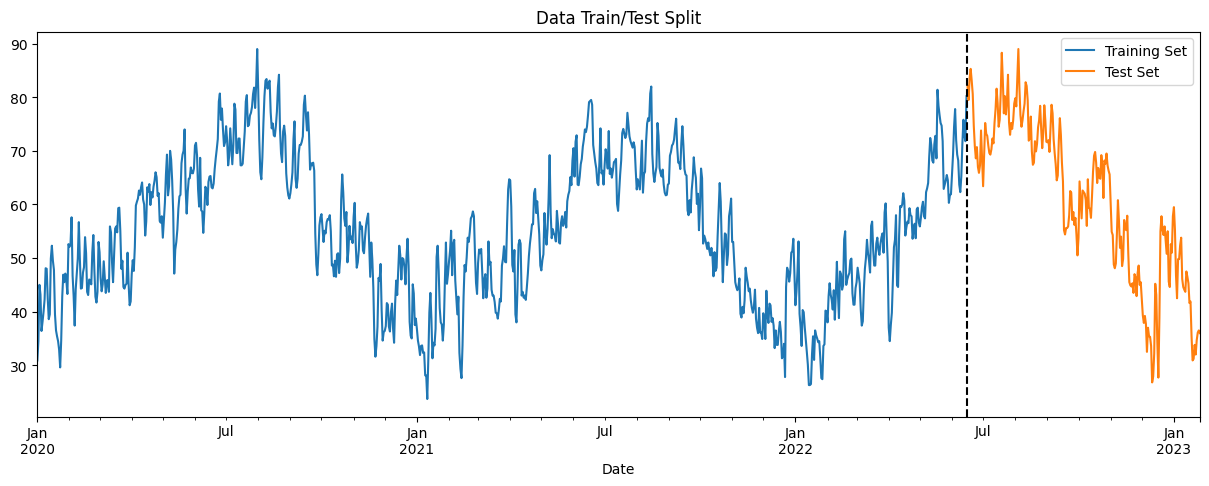

In [210]:

fig, ax = plt.subplots(figsize=(15, 5))
train['Temp_avg'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['Temp_avg'].plot(ax=ax, label='Test Set')
ax.axvline('2022-06-15', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Pyspark

In [ ]:
from pyspark.sql.functions import dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df2 = df.withColumn("dayofweek", dayofweek(df.index)) \
            .withColumn("quarter", quarter(df.index)) \
            .withColumn("month", month(df.index)) \
            .withColumn("year", year(df.index)) \
            .withColumn("dayofyear", dayofyear(df.index)) \
            .withColumn("dayofmonth", dayofmonth(df.index)) \
            .withColumn("weekofyear", weekofyear(df.index))
    return df2


train_df = create_features(train_df)
test_df = create_features(test_df)

train_spark = spark.createDataFrame(train)
test_spark = spark.createDataFrame(test)

In [40]:
from pyspark.sql.functions import *

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Temp_avg'

X_train = train_df.select(*FEATURES)
y_train = train_df.select(TARGET)

X_test = test_df.select(*FEATURES)
y_test = test_df.select(TARGET)


**Create features in Pandas**

In [211]:
#train_t = train['Temp_avg']
#test_t = test['Temp_avg']

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

#train_t = create_features(train)


In [212]:
train_t = create_features(train)
test_t = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Temp_avg'

X_train = train_t[FEATURES]
y_train = train_t[TARGET]

X_test = test_t[FEATURES]
y_test = test_t[TARGET]

In [213]:
X_train

,dayofyear,dayofweek,quarter,month,year
Date,,,,,
2020-01-01,1,2,1,1,2020
2020-01-02,2,3,1,1,2020
2020-01-03,3,4,1,1,2020
2020-01-04,4,5,1,1,2020
2020-01-05,5,6,1,1,2020
...,...,...,...,...,...
2022-06-11,162,5,2,6,2022
2022-06-12,163,6,2,6,2022
2022-06-13,164,0,2,6,2022


In [177]:
#pip install xgboost

In [214]:
import xgboost as xgb

In [215]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[11:08:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:55.58202	validation_1-rmse:61.54312
[100]	validation_0-rmse:21.25550	validation_1-rmse:26.22697
[200]	validation_0-rmse:9.52672	validation_1-rmse:14.04023
[300]	validation_0-rmse:6.16633	validation_1-rmse:9.69153
[400]	validation_0-rmse:5.40043	validation_1-rmse:8.16762
[500]	validation_0-rmse:5.16768	validation_1-rmse:7.58953
[600]	validation_0-rmse:5.03181	validation_1-rmse:7.46574
[700]	validation_0-rmse:4.90509	validation_1-rmse:7.40598
[800]	validation_0-rmse:4.79009	validation_1-rmse:7.38377
[848]	validation_0-rmse:4.74410	validation_1-rmse:7.39368


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

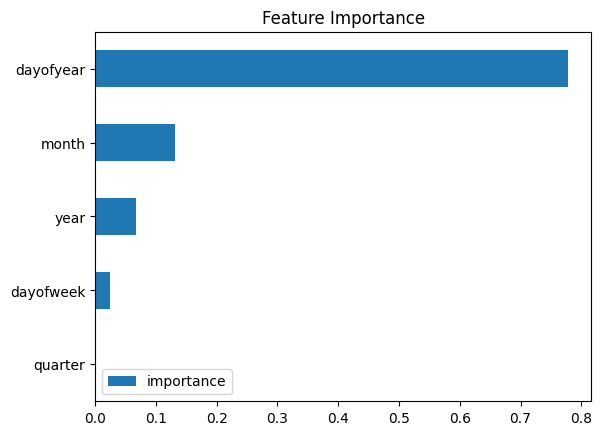

In [216]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [220]:
test = test
train = train
test['prediction'] = reg.predict(X_test)
df_total = train.merge(test[['prediction']], how='left', left_index=True, right_index=True)
#ax = df_total[['Temp_avg']].plot(figsize=(15, 5))
#df_total['prediction'].plot(ax=ax, style='-')
#plt.legend(['Truth Data', 'Predictions'])
#ax.set_title('Raw Dat and Prediction')
#plt.show()

C:\Users\LAAUMAR\AppData\Local\Temp\ipykernel_4592\2069661187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


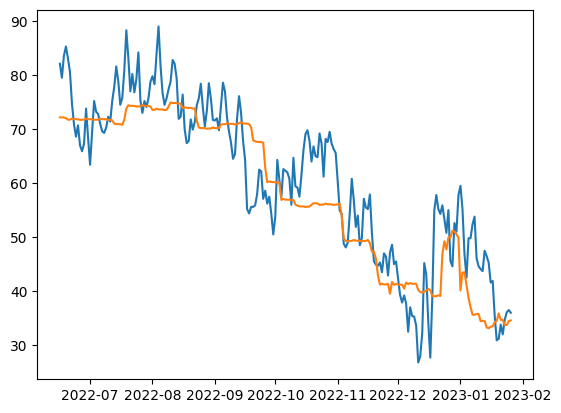

In [221]:
plt.plot(y_test)
plt.plot(test['prediction'])

In [222]:
from sklearn.metrics import mean_absolute_error
import numpy as np

In [223]:
score = np.sqrt(mean_absolute_error(y_test, test['prediction']))
print(f'MAE Score on Test set: {score:0.2f}')

MAE Score on Test set: 2.43


In [110]:
#test.index = test['index']

In [224]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

C:\Users\LAAUMAR\AppData\Local\Temp\ipykernel_4592\3393641776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test[TARGET] - test['prediction'])
C:\Users\LAAUMAR\AppData\Local\Temp\ipykernel_4592\3393641776.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = test.index


date
2023-01-01    19.367653
2022-12-20    18.738515
2023-01-08    18.174062
2023-01-07    16.768523
2022-09-18    16.504022
2022-12-21    15.958823
2022-12-19    15.938515
2022-09-17    15.825795
2022-08-04    15.337929
2022-12-22    15.190648
Name: error, dtype: float64

In [225]:
reg.predict(np.array([180, 5, 2, 6, 2024]).reshape(1,5))

array([71.82759], dtype=float32)